In [1]:
# !pip install pymc
# !pip install pyreadstat 
# sav_data = pd.read_spss('sav_data.sav"')"
# sav_data.to_csv('csv_data.csv', index=False)

In [2]:
#@title Imports and load google drive, navigate to BPD folder
import pandas as pd
import numpy as np
import scipy.stats as stat
# import arviz as az
import matplotlib.pyplot as plt
from scipy.special import softmax
from scipy.optimize import minimize
# import pytensor
# import pytensor.tensor as pt
import scipy
# import hddm
import seaborn as sns

import statsmodels.api as sm
import statsmodels.formula.api as smf
import multiprocessing as mp



In [3]:
data = pd.read_csv('new_d.csv').drop('Unnamed: 0', axis = 1)

In [5]:
data = data.sort_values(['ID', 'Session', 'Block'], ascending=[True, True, True]).reset_index().drop('index', axis = 1)
data['optimal response taken'] = data['StimulusPresentation1.RESP'] == data['StimulusPresentation1.CRESP']

In [4]:
#Generated trial behavior
num_trials = 360
possible_trials = np.concatenate((np.tile([[0, 1]], int(num_trials/3)).reshape(int(num_trials/3), 2), np.tile([[2, 3]], int(num_trials/3)).reshape(int(num_trials/3), 2), np.tile([[4, 5]], int(num_trials/3)).reshape(int(num_trials/3), 2)))
np.random.shuffle(possible_trials)

rewards = np.zeros_like(possible_trials)
for i, trial in enumerate(possible_trials): 
    if trial[0] == 0:
        rewards[i][0] = np.random.choice([1, 0], p = [.80, .20])
        rewards[i][1] = np.random.choice([0, 1], p = [.80, .20])
    elif trial[0] == 2: 
        rewards[i][0] = np.random.choice([1, 0], p = [.70, .30])
        rewards[i][1] = np.random.choice([0, 1], p = [.70, .30])
    else:
        rewards[i][0] = np.random.choice([1, 0], p = [.60, .40])
        rewards[i][1] = np.random.choice([0, 1], p = [.60, .40])
        
optimal_choices = np.zeros(num_trials)
optimal_choices[np.where(possible_trials == [2])[0]] = 2
optimal_choices[np.where(possible_trials == [4])[0]] = 4


In [27]:
procedure = 'Trainb'
ID = 1006
trials_presented = np.array([np.array([int(i), int(j)]) for i, j in data.loc[((data['ID'] == ID) & (data['Procedure'] == procedure)), 'TrialType'].str.replace('A', '0').str.replace('B', '1').str.replace('C', '2').str.replace('D', '3').str.replace('E', '4').str.replace('F', '5').values])

actions = np.zeros(len(trials_presented))
chosen = data.loc[((data['ID'] == ID) & (data['Procedure'] == procedure)), 'StimulusPresentation1.RESP'].values.astype(int)
for i, trial in enumerate(trials_presented):
    actions[i] = int(trial[1 - chosen[i]])
actions = actions.astype(int)

optimal_resp = data.loc[((data['ID'] == ID) & (data['Procedure'] == procedure)), 'optimal response taken'].values.astype(int)

rewards = data.loc[((data['ID'] == ID) & (data['Procedure'] == procedure)), 'StimulusPresentation1.ACC'].values.astype(int)


In [28]:
rng = np.random.default_rng(12345)

def generate_data(rng, alpha_l, alpha_g, beta, stimuli, p_r=None):
    n = len(stimuli)
    if p_r is None:
        p_r = [0.8, 0.2, 0.7, 0.3, 0.6, 0.4]
    actions = np.zeros(n, dtype="int")
    optimal_action_taken = np.zeros(n, dtype="int")
    rewards = np.zeros(n, dtype="int")
    Qs = np.zeros((n, len(p_r)))

    # Initialize Q table
    Q = np.array([0.5, 0.5, 0.5, 0.5, 0.5, 0.5])

    for i in range(n):
        # Apply the Softmax transformation
        exp_Q = np.exp(Q[stimuli[i]]*beta)
        prob_a = exp_Q / np.sum(exp_Q)
        # print(prob_a)
        # Simulate choice and reward
        a = rng.choice(stimuli[i], p=prob_a)
        r = rng.random() < p_r[a]

        # Update Q table
        pred_error = r - Q[a]
        if pred_error > 0:
            alpha = alpha_g
        else:
            alpha = alpha_l

        Q[a] = Q[a] + alpha * (r - Q[a])

        # Store values
        actions[i] = a
        rewards[i] = r
        optimal_action_taken[i] = int(a%2 == 0)
        Qs[i][a] = Q[a]

    return actions, rewards, optimal_action_taken, Qs

In [29]:
actions, rewards, opt_act, Qs = generate_data(rng, 1, 1, 1, trials_presented.astype(int))

In [138]:
# true_alpha_l = 0.1
# true_alpha_g = 0.4
# true_beta = 10


array([2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 1, 2,
       2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 1, 2, 2, 1, 2, 1, 1, 2, 2, 1,
       2, 1, 1, 2, 2, 1, 1, 2, 2, 1, 2, 1, 2, 1, 1, 2, 2, 1, 1, 2, 2, 1,
       1, 2, 2, 1, 2, 1, 1, 2, 1, 2, 2, 1, 2, 1, 2, 1, 2, 1, 1, 2, 2, 1,
       2, 1, 2, 1, 2, 1, 1, 2, 2, 1, 1, 2, 2, 1, 1, 2, 2, 1, 2, 1, 1, 2,
       2, 1, 2, 1, 1, 2, 2, 1, 2, 1, 1, 2, 2, 1, 1, 2, 2, 1, 2, 1, 1, 2,
       1, 2, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 1, 2, 1, 2, 1, 2, 2, 1, 2, 1,
       2, 1, 2, 1, 2, 1, 1, 2, 1, 2, 1, 2, 1, 2, 2, 1, 2, 1, 1, 2, 2, 1,
       2, 1, 2, 1, 1, 2, 2, 1, 1, 2, 2, 1, 1, 2, 1, 2, 2, 1, 2, 1, 1, 2,
       1, 2, 2, 1, 1, 2, 2, 1, 1, 2, 1, 2, 1, 2, 2, 1, 2, 1, 2, 1, 1, 2,
       2, 1, 1, 2, 2, 1, 2, 1, 2, 1, 1, 2, 1, 2, 1, 2, 2, 1, 2, 1, 2, 1,
       1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 2, 1, 1, 2, 2, 1, 2, 1])

In [34]:
df_list = []
for ID in data['ID'].unique():

    trials_presented = np.array([np.array([int(i), int(j)]) for i, j in data.loc[((data['ID'] == ID) & (data['Procedure'] == procedure)), 'TrialType'].str.replace('A', '0').str.replace('B', '1').str.replace('C', '2').str.replace('D', '3').str.replace('E', '4').str.replace('F', '5').values])

    # actions, rewards, optimal_action_taken, Qs = generate_data(rng, true_alpha_l, true_alpha_g, true_beta, trials_presented, p_r=None)

    actions = np.zeros(len(trials_presented))
    chosen = data.loc[((data['ID'] == ID) & (data['Procedure'] == procedure)), 'StimulusPresentation1.RESP'].values.astype(int)
    for i, trial in enumerate(trials_presented):
        try:
            actions[i] = int(trial[1 - chosen[i]])
        except:
            continue
#             print(actions[i])
#             print(ID)
    actions = actions.astype(int)

    optimal_resp = data.loc[((data['ID'] == ID) & (data['Procedure'] == procedure)), 'optimal response taken'].values.astype(int)

    rewards = data.loc[((data['ID'] == ID) & (data['Procedure'] == procedure)), 'StimulusPresentation1.ACC'].values.astype(int)

#     sessions = pd.
    trials_presented = data.loc[((data['ID'] == ID) & (data['Procedure'] == procedure)), 'TrialType'].values
    trials_presented[trials_presented == 'BA'] = 'AB'
    trials_presented[trials_presented == 'DC'] = 'CD'
    trials_presented[trials_presented == 'FE'] = 'EF'

    df = pd.DataFrame({'subj_idx': np.repeat(ID, len(trials_presented)),
                       'response': optimal_resp,
                       'feedback': rewards,
                       'cond': trials_presented,
                       'Session': data.loc[((data['ID'] == ID) & (data['Procedure'] == procedure)), 'Session'].values
                      }                 
                     )
    df.loc[((df['cond'] == 'AB') & (df['Session'] == 1)), 'trial'] = np.arange(len(df.loc[((df['cond'] == 'AB') & (df['Session'] == 1))]))
    df.loc[((df['cond'] == 'CD') & (df['Session'] == 1)), 'trial'] = np.arange(len(df.loc[((df['cond'] == 'CD') & (df['Session'] == 1))]))
    df.loc[((df['cond'] == 'EF') & (df['Session'] == 1)), 'trial'] = np.arange(len(df.loc[((df['cond'] == 'EF') & (df['Session'] == 1))]))

    df.loc[((df['cond'] == 'AB') & (df['Session'] == 2)), 'trial'] = np.arange(len(df.loc[((df['cond'] == 'AB') & (df['Session'] == 2))]))
    df.loc[((df['cond'] == 'CD') & (df['Session'] == 2)), 'trial'] = np.arange(len(df.loc[((df['cond'] == 'CD') & (df['Session'] == 2))]))
    df.loc[((df['cond'] == 'EF') & (df['Session'] == 2)), 'trial'] = np.arange(len(df.loc[((df['cond'] == 'EF') & (df['Session'] == 2))]))
    
    
    df['rt'] = 0.5
    df['q_init'] = 0.5
    df.loc[((df['cond'] == 'AB')), 'split_by'] = int(0)
    df.loc[((df['cond'] == 'CD')), 'split_by'] = int(1)
    df.loc[((df['cond'] == 'EF')), 'split_by'] = int(2)

    if (data.loc[data['ID'] == ID, 'BPD#'].unique()[0] > 5):
        df['BPD'] = 'BPD'
    else:
        df['BPD'] = 'No BPD'
    df['Condition'] = str(data.loc[data['ID'] == ID, 'Condition'].unique()[0])
    
    df_list.append(df)

<ipython-input-34-6c439b1f2d2b>:12: RuntimeWarning: overflow encountered in long_scalars
  actions[i] = int(trial[1 - chosen[i]])


In [35]:
df = pd.concat(df_list)
# df.loc[df['BPD'] == False] = 'No BPD'


In [36]:
df.loc[df['Session'] == 1, 'Session'] = 'Neutral'
df.loc[df['Session'] == 2, 'Session'] = 'Stressed'

df.loc[df['Condition'] == 1, 'Condition'] = 'NonSocial'
df.loc[df['Condition'] == 2, 'Condition'] = 'Social'



# Hierarchical Model

In [324]:
m_hrl = hddm.Hrl(df, depends_on = {'alpha':['Session', 'BPD', 'Condition'], 'pos_alpha':['Session', 'BPD', 'Condition'], 'v':['Session', 'BPD', 'Condition']}, p_outlier = 0.05, dual = True)
m_hrl.sample(4000, burn=1000, dbname="traces.db", db="pickle")


No model attribute --> setting up standard HDDM
Set model to ddm


/opt/conda/lib/python3.8/site-packages/hddm/models/base.py:1307: UserWarning:  
 Your include statement misses either the v, a or t parameters. 
Parameters not explicitly included will be set to the defaults, 
which you can find in the model_config dictionary!
  warnings.warn(


 [-----------------100%-----------------] 4001 of 4000 complete in 1919.5 sec

In [242]:
traces = m_hrl.get_traces()

In [245]:
traces.to_csv('traces.csv')

In [327]:
stat_traces = m_hrl.gen_stats().reset_index()
stat_traces = stat_traces.rename(columns={'index':'parameters'})

In [328]:
stat_traces.to_csv('stat_traces.csv')

In [399]:
def plotting_q(stat_traces, condition):

    alpha_g25 = stat_traces.loc[((stat_traces.parameters.str.contains(condition)) & (stat_traces.parameters.str.contains('pos_alpha_sub')))]['2.5q'].values
    alpha_g975 = stat_traces.loc[((stat_traces.parameters.str.contains(condition)) & (stat_traces.parameters.str.contains('pos_alpha_sub')))]['97.5q'].values

    alpha_l25 = stat_traces[stat_traces.parameters.str.contains(condition) & stat_traces.parameters.str.startswith('alpha_sub')]['2.5q'].values
    alpha_l975 = stat_traces[stat_traces.parameters.str.contains(condition) & stat_traces.parameters.str.startswith('alpha_sub')]['97.5q'].values

    beta_25 = stat_traces[stat_traces.parameters.str.contains(condition) & stat_traces.parameters.str.startswith('v_sub')]['2.5q'].values
    beta_975 = stat_traces[stat_traces.parameters.str.contains(condition) & stat_traces.parameters.str.startswith('v_sub')]['97.5q'].values

    alpha_g25 = np.exp(alpha_g25.astype(float))/(1+np.exp(alpha_g25.astype(float)))
    alpha_g975 = np.exp(alpha_g975.astype(float))/(1+np.exp(alpha_g975.astype(float)))

    alpha_l25 = np.exp(alpha_l25.astype(float))/(1+np.exp(alpha_l25.astype(float)))
    alpha_l975 = np.exp(alpha_l975.astype(float))/(1+np.exp(alpha_l975.astype(float)))
    print(alpha_l25)
    
    plt.subplot(1, 3, 1)
    plt.plot([alpha_g25, alpha_g975], [0.1*np.arange(len(alpha_g25)), 0.1*np.arange(len(alpha_g975))])
    plt.xlim((0, 1))
#     plt.ylabel('Participants')
    plt.xlabel('HDIs')
    plt.title('Alpha Gain')
#     plt.show()

    plt.subplot(1, 3, 2)
    plt.plot([alpha_l25, alpha_l975], [0.1*np.arange(len(alpha_l25)), 0.1*np.arange(len(alpha_l975))])
    plt.xlim((0, 1))
#     plt.ylabel('Participants')
    plt.xlabel('HDIs')
    plt.title('Alpha Loss')
#     plt.show()
    
    
    plt.subplot(1, 3, 3)
    plt.plot([beta_25, beta_975], [0.1*np.arange(len(beta_25)), 0.1*np.arange(len(beta_975))])
    plt.xlim((0, 1))
    plt.ylabel('Participants')
    plt.xlabel('HDIs')
    plt.title('Beta')
    plt.show()

[0.00335162 0.00248443 0.00260421 0.00091698 0.14987775 0.0060188
 0.00041901 0.00688423 0.00104464 0.00743658 0.04734519 0.00721574
 0.00380042]


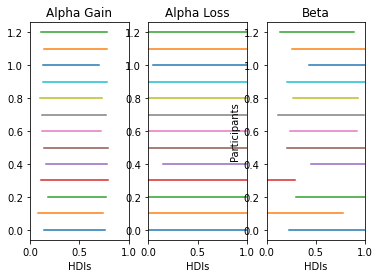

In [418]:
plotting_q(stat_traces, '\(BPD.2.Stressed')

# Non Hierarchical Model

In [421]:
m_non_hierarchical_rl = hddm.Hrl(df, depends_on = {'alpha':['Session'], 'pos_alpha':['Session'], 'v':['Session']}, p_outlier = 0.05, dual = True)
m_non_hierarchical_rl.sample(4000, burn=1000, dbname="traces.db", db="pickle")


No model attribute --> setting up standard HDDM
Set model to ddm
 [-----------------100%-----------------] 4000 of 4000 complete in 1847.2 sec

In [422]:
m_non_hierarchical_rl.get_traces().to_csv('non_hierarchical_traces.csv')

In [429]:
non_hierarchical_rl_stats = m_non_hierarchical_rl.gen_stats().reset_index().rename(columns = {'index':'parameters'})

In [430]:
non_hierarchical_rl_stats.to_csv('non_hierarchical_rl_stats.csv')


In [459]:
non_hrl_params = non_hierarchical_rl_stats[['parameters', 'mean', '50q']]


In [460]:
non_hrl_params.loc[non_hrl_params.parameters.str.contains('alpha'), '50q'] = np.exp(non_hrl_params.loc[non_hrl_params.parameters.str.contains('alpha'), '50q'].values.astype(float))/(1+ np.exp(non_hrl_params.loc[non_hrl_params.parameters.str.contains('alpha'), '50q'].values.astype(float)))
non_hrl_params.loc[non_hrl_params.parameters.str.contains('alpha'), 'mean'] = np.exp(non_hrl_params.loc[non_hrl_params.parameters.str.contains('alpha'), 'mean'].values.astype(float))/(1+ np.exp(non_hrl_params.loc[non_hrl_params.parameters.str.contains('alpha'), 'mean'].values.astype(float)))


/opt/conda/lib/python3.8/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
<ipython-input-460-8b97d86d59fc>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_hrl_params.loc[non_hrl_params.parameters.str.contains('alpha'), '50q'] = np.exp(non_hrl_params.loc[non_hrl_params.parameters.str.contains('alpha'), '50q'].values.astype(float))/(1+ np.exp(non_hrl_params.loc[non_hrl_params.parameters.str.contains('alpha'), '50q'].values.astype(float)))
<ipython-input-460-8b97d86d59fc>:2: SettingWithCopyWarning: 
A value is trying to be set on a cop

In [462]:
non_hrl_params.to_csv('non_hrl_params.csv')

In [463]:
non_hrl_params

,parameters,mean,50q
0,v(Neutral),0.304987,0.302219
1,v(Stressed),0.427031,0.426332
2,v_std,0.279949,0.278573
3,v_subj(Neutral).1001,0.249379,0.244112
4,v_subj(Neutral).1002,-0.0778145,-0.0773303
...,...,...,...
907,pos_alpha_subj(Stressed).1232,0.367232,0.353756
908,pos_alpha_subj(Stressed).1237,0.443505,0.463304
909,pos_alpha_subj(Stressed).1243,0.369866,0.405974
910,pos_alpha_subj(Stressed).1247,0.352087,0.375754


# Models using Traces

In [65]:
traces = pd.read_csv('non_hierarchical_traces.csv').drop('Unnamed: 0', axis = 1).reset_index().rename(columns = {'index':'trace#'})

In [70]:
rng = np.random.default_rng()

In [71]:
new_traces = pd.DataFrame({'trace#': np.arange(3000)})
for column in traces.columns:
    new_traces[column] = rng.permuted(traces[column].values)

/tmp/ipykernel_5255/3584588551.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_traces[column] = rng.permuted(traces[column].values)
/tmp/ipykernel_5255/3584588551.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_traces[column] = rng.permuted(traces[column].values)
/tmp/ipykernel_5255/3584588551.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. 

/tmp/ipykernel_5255/3584588551.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_traces[column] = rng.permuted(traces[column].values)
/tmp/ipykernel_5255/3584588551.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_traces[column] = rng.permuted(traces[column].values)
/tmp/ipykernel_5255/3584588551.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. 

In [85]:
traces_melt = new_traces.melt(id_vars='trace#', var_name='parameters', value_name='parameter values')

In [86]:
traces_melt = traces_melt[traces_melt.parameters.str.contains('subj')]

In [87]:
traces_melt.loc[traces_melt.parameters.str.contains('Neutral'), 'Session'] = 'Neutral'
traces_melt.loc[traces_melt.parameters.str.contains('Stressed'), 'Session'] = 'Stressed'



In [88]:
traces_melt[['parameters', 'ID']] = traces_melt.parameters.str.split('.', expand=True)

In [89]:
traces_melt.loc[traces_melt.parameters.str.contains('alpha'), 'parameter values'] = np.exp(traces_melt.loc[traces_melt.parameters.str.contains('alpha'), 'parameter values'])/(1+np.exp(traces_melt.loc[traces_melt.parameters.str.contains('alpha'), 'parameter values']))

In [91]:
for ids in traces_melt.ID.unique():
    traces_melt.loc[traces_melt['ID'] == ids, 'BPD'] = data.loc[data['ID'] == int(ids), 'BPD#'].unique()[0]
    traces_melt.loc[traces_melt['ID'] == ids, 'Condition'] = data.loc[data['ID'] == int(ids), 'Condition'].unique()[0]
    

In [92]:
traces_melt

,trace#,parameters,parameter values,Session,ID,BPD,Condition
9000,0,v_subj(Neutral),0.029903,Neutral,1001,0.0,2.0
9001,1,v_subj(Neutral),0.366367,Neutral,1001,0.0,2.0
9002,2,v_subj(Neutral),0.229726,Neutral,1001,0.0,2.0
9003,3,v_subj(Neutral),0.162186,Neutral,1001,0.0,2.0
9004,4,v_subj(Neutral),0.379577,Neutral,1001,0.0,2.0
...,...,...,...,...,...,...,...
2735995,2995,pos_alpha_subj(Stressed),0.142009,Stressed,1249,4.0,2.0
2735996,2996,pos_alpha_subj(Stressed),0.254487,Stressed,1249,4.0,2.0
2735997,2997,pos_alpha_subj(Stressed),0.384634,Stressed,1249,4.0,2.0
2735998,2998,pos_alpha_subj(Stressed),0.500698,Stressed,1249,4.0,2.0


In [11]:
def lm_params(trace_no, parameter = 'pos_alpha_subj'):
    temp_data = traces_melt.loc[((traces_melt['trace#'] ==trace_no) & (traces_melt['parameters'].str.startswith(parameters)))].rename(columns={'parameter values':'param_vals'})
    res = smf.ols(formula='param_vals ~  BPD*Session*C(Condition) -1 ', data=temp_data).fit()
#     d_list.append(pd.DataFrame(res.params))
    return res.params

In [ ]:
trace_nos = np.arange(3000)
pool = mp.Pool()
pos_alpha_results = pool.map(lm_params, trace_nos)

In [3]:
# pos_alpha = lm_params('pos_alpha_subj')
# neg_alpha = lm_params('pos_alpha_subj')
# beta = lm_params('v_subj')


In [139]:
pos_alpha = pos_alpha.reset_index().rename(columns={'index':'coefficient'})

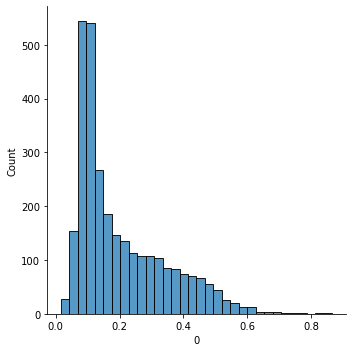

In [166]:
sns.displot(pos_alpha.iloc[0][1:])

# Analyzing/Plotting Fit Linear Model parameters

In [13]:
alpha_g = pd.read_csv('alpha_g.csv').drop('Unnamed: 0', axis = 1)
alpha_l = pd.read_csv('alpha_l.csv').drop('Unnamed: 0', axis = 1)
beta = pd.read_csv('beta.csv').drop('Unnamed: 0', axis = 1)

In [82]:
alpha_g_melt = alpha_g.melt(id_vars='coefficient', value_name='value', var_name='trace')
alpha_l_melt = alpha_l.melt(id_vars='coefficient', value_name='value', var_name='trace')
beta_melt = beta.melt(id_vars='coefficient', value_name='value', var_name='trace')


Text(0.5, 1.0, 'Alpha Gain')

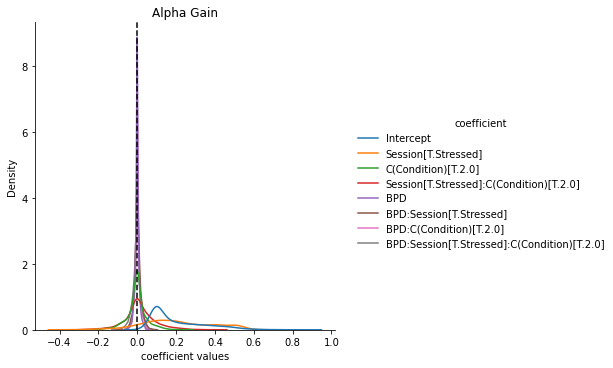

In [84]:
g = sns.displot(alpha_g_melt, kind = 'kde', hue = 'coefficient', x = 'value')
g.axes[0][0].axvline(x = 0, ls = '--', color = 'black')
g.axes[0][0].set_xlabel('coefficient values')
g.axes[0][0].set_title('Alpha Gain')
# sns.displot(alpha_g.iloc[0][1:])


Text(0.5, 1.0, 'Alpha Loss')

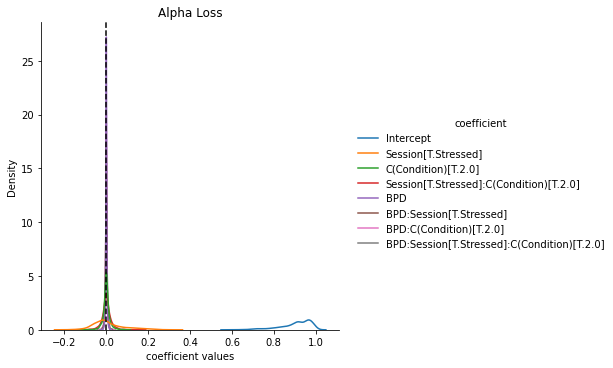

In [85]:
g = sns.displot(alpha_l_melt, kind = 'kde', hue = 'coefficient', x = 'value')
g.axes[0][0].axvline(x = 0, ls = '--', color = 'black')
g.axes[0][0].set_xlabel('coefficient values')
g.axes[0][0].set_title('Alpha Loss')

Text(0.5, 1.0, 'Beta')

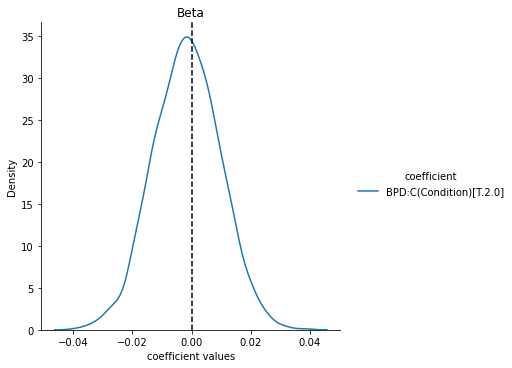

In [89]:
g = sns.displot(beta_melt.loc[beta_melt['coefficient'] == 'BPD:C(Condition)[T.2.0]'], kind = 'kde', hue = 'coefficient', x = 'value')
g.axes[0][0].axvline(x = 0, ls = '--', color = 'black')
g.axes[0][0].set_xlabel('coefficient values')
g.axes[0][0].set_title('Beta')

In [ ]:
sns.displot(alpha_g_melt, kind = 'kde', hue = 'coefficient', x = 'value')

### Correlations and Autocorrelations 

In [13]:
traces = pd.read_csv('non_hierarchical_traces.csv').drop(['Unnamed: 0', 'v(Neutral)', 'v(Stressed)', 'v_std', 'alpha(Neutral)', 'alpha(Stressed)', 'alpha_std', 'pos_alpha(Neutral)', 'pos_alpha(Stressed)', 'pos_alpha_std'], axis = 1).reset_index().rename(columns = {'index':'trace#'})

In [28]:
beta_traces_neutral = traces.iloc[:, range(1,151)]
beta_traces_stressed = traces.iloc[:, range(151,301)]

alpha_l_traces_neutral = traces.iloc[:, range(301,451)]
alpha_l_traces_stressed = traces.iloc[:, range(451,601)]

alpha_g_traces_neutral = traces.iloc[:, range(601,751)]
alpha_g_traces_stressed = traces.iloc[:, range(751,901)]


Text(0.5, 1.0, 'Beta Stressed')

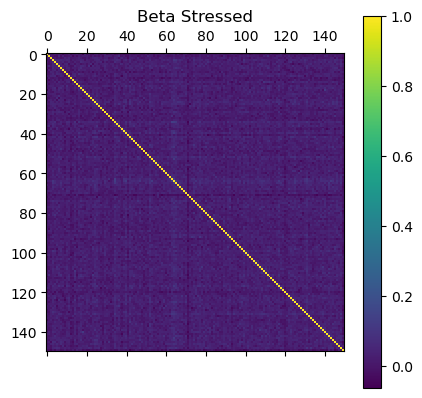

In [48]:
plt.matshow(beta_traces_stressed.corr())
cb = plt.colorbar()
plt.title('Beta Stressed')

In [26]:
traces

,trace#,v_subj(Neutral).1001,v_subj(Neutral).1002,v_subj(Neutral).1003,v_subj(Neutral).1004,v_subj(Neutral).1005,v_subj(Neutral).1006,v_subj(Neutral).1007,v_subj(Neutral).1009,v_subj(Neutral).1011,...,pos_alpha_subj(Stressed).1227,pos_alpha_subj(Stressed).1228,pos_alpha_subj(Stressed).1229,pos_alpha_subj(Stressed).1230,pos_alpha_subj(Stressed).1231,pos_alpha_subj(Stressed).1232,pos_alpha_subj(Stressed).1237,pos_alpha_subj(Stressed).1243,pos_alpha_subj(Stressed).1247,pos_alpha_subj(Stressed).1249
0,0,0.029903,-0.039134,0.034183,0.184112,0.040938,0.350309,0.411380,0.048479,0.132578,...,-0.439923,-1.075831,-0.515417,-0.430046,-1.105739,0.819924,-1.310323,0.457256,0.881738,0.024868
1,1,0.366367,-0.083299,-0.399781,0.151578,0.016453,-0.001424,0.620762,0.221516,0.149196,...,0.252068,-0.060226,0.279486,-0.211685,-0.186464,-1.181504,-1.711932,0.477200,0.231048,-1.244038
2,2,0.229726,-0.066812,-0.343848,0.082362,0.019411,0.497573,0.626950,0.325959,0.204904,...,0.168571,-2.485794,-0.470749,-0.063211,0.402376,-0.298957,-1.309395,0.092458,-0.497235,-1.453153
3,3,0.162186,-0.144125,0.000877,0.212162,-0.071375,0.148373,0.522429,0.170610,0.162229,...,0.064314,0.369088,-0.005620,-0.731423,0.242072,-1.649430,0.591059,-0.288653,-0.342907,0.086320
4,4,0.379577,-0.087884,-0.105505,0.253899,-0.012772,0.060058,0.531749,0.213135,0.166050,...,1.272461,-0.992769,0.725387,-1.281259,0.421960,0.192549,-0.236082,-1.250505,-1.051666,-0.667351
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,2995,0.492073,0.154232,-0.081988,0.435237,-0.034100,0.203057,0.373269,0.350930,0.369441,...,-2.448346,0.725433,1.226183,2.423461,1.803074,2.160093,2.563774,-0.826662,11.067562,-1.798702
2996,2996,-0.215581,-0.226232,-0.027959,0.324292,-0.163487,0.329424,0.562902,0.218108,0.196141,...,3.839343,1.419904,-0.047518,8.175656,-4.655764,1.174284,0.644791,1.632369,-1.427574,-1.074820
2997,2997,0.118326,-0.369620,-0.067286,0.425057,0.073191,0.096413,0.496309,0.384373,0.254282,...,-1.789965,-2.370185,1.704978,-3.282537,4.528257,1.279255,-3.670981,2.292277,2.922054,-0.469925
2998,2998,0.142425,-0.135698,-0.183635,0.430008,-0.038479,0.164332,0.251911,0.398588,0.103799,...,-3.524078,-2.792114,-1.121180,0.861291,-2.279373,-0.294365,-2.417826,1.516108,-4.685720,0.002790


In [15]:
traces_melt = traces.melt(id_vars='trace#', var_name='parameters', value_name='parameter values')

In [17]:
neutral_traces_melt = traces_melt.loc[traces_melt.parameters.str.contains('Neutral')].reset_index()
stressed_traces_melt = traces_melt.loc[traces_melt.parameters.str.contains('Stressed')].reset_index()


In [56]:
neutral_traces_melt.sample()

,index,trace#,parameters,parameter values
1129394,2023394,1394,pos_alpha_subj(Neutral).1097,-2.392515


# Optimal Parameters

In [6]:
rng = np.random.default_rng(12345)

def optimal_model(rng, alpha_l, alpha_g, num_trials):
    Q = np.zeros(2)+0.5
    choices = []
    for i in range(num_trials):
#         choice_a = np.random.choice([0, 1], p = softmax(Q))
        choice_a = np.argmax(Q)
        if choice_a == 0:
            reward = np.random.choice([1, 0], p=[0.8, 0.2])
        else:
            reward = np.random.choice([1, 0], p=[0.2, 0.8])
            
        pred_error = reward - Q[choice_a]
        if pred_error > 0:
            alpha = alpha_l
        else:
            alpha = alpha_g
        Q[choice_a] = Q[choice_a] + alpha*pred_error
        choices.append(choice_a)
    return 1 - (sum(choices)/len(choices))


In [7]:
num_trials = 1000
n_sims = 1000
df = []
for (alpha_l, alpha_g) in zip([0.1, 0.6, 0.9, 1], [0.1, 0.6, 0.9, 1]):
    optimal_choice_proportion = np.zeros(n_sims)
    for i in range(n_sims):
        optimal_choice_proportion[i] = optimal_model(rng, alpha_l, alpha_g, num_trials)
    df.append(pd.DataFrame({'Alpha_l': np.repeat(alpha_l, n_sims), 'Alpha_g': np.repeat(alpha_g, n_sims), 'optimal choice proportion': optimal_choice_proportion}))


In [8]:
sim_data = pd.concat(df)

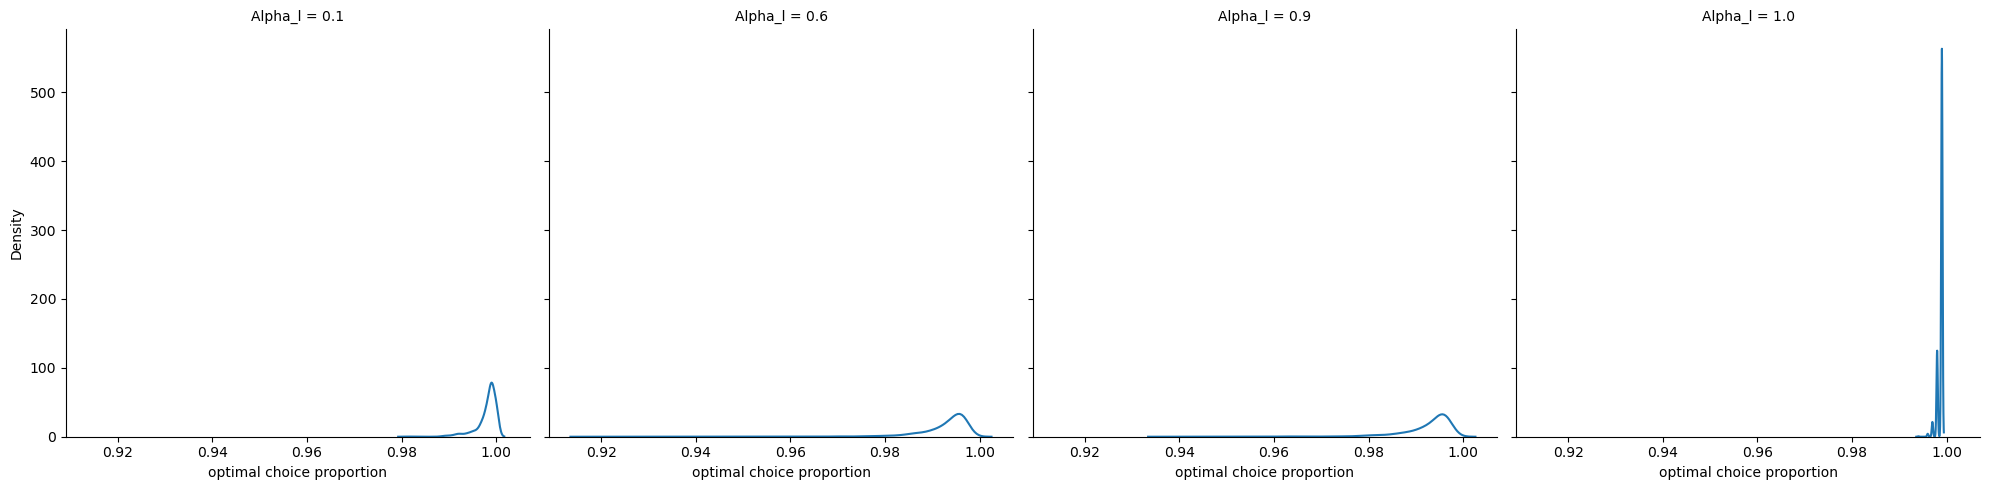

In [9]:
sns.displot(x = 'optimal choice proportion', data = sim_data, col = 'Alpha_l', kind = 'kde')

# Other stuff tried

In [8]:
def llik_td (alpha_l, alpha_g, beta, actions, rewards, stimuli):
    # Extract the arguments as they are passed by scipy.optimize.minimize

    # Initialize values
    Q = np.array([0.5, 0.5, 0.5, 0.5, 0.5, 0.5])
    logp_actions = np.zeros(len(actions))

    for t, (a, r) in enumerate(zip(actions, rewards)):
        # Apply the softmax transformation
        exp_Q = np.exp(Q[stimuli[t]]*beta)
        
        prob_a = exp_Q / np.sum(exp_Q)

#         logp_action = Q_ - scipy.special.logsumexp(Q_)

        # Store the log probability of the observed action
        logp_actions[t] = np.log(prob_a[a%2])
        
        

        # Update the Q values for the next trial
        pred_error = r - Q[a]
        if pred_error > 0:
            alpha = alpha_g
        else:
            alpha = alpha_l
            
        Q[a] = Q[a] + alpha * pred_error

    # Return the negative log likelihood of all observed actions
    return np.sum(logp_actions[1:])


# define a pytensor Op for our likelihood function
class LogLike(pt.Op):

    """
    Specify what type of object will be passed and returned to the Op when it is
    called. In our case we will be passing it a vector of values (the parameters
    that define our model) and returning a single "scalar" value (the
    log-likelihood)
    """

    itypes = [pt.dvector]  # expects a vector of parameter values when called
    otypes = [pt.dscalar]  # outputs a single scalar value (the log likelihood)

    def __init__(self, loglike, actions, rewards, stimuli):
        """
        Initialise the Op with various things that our log-likelihood function
        requires. Below are the things that are needed in this particular
        example.

        Parameters
        ----------
        loglike:
            The log-likelihood (or whatever) function we've defined
        data:
            The "observed" data that our log-likelihood function takes in
        x:
            The dependent variable (aka 'x') that our model requires
        sigma:
            The noise standard deviation that our function requires.
        """

        # add inputs as class attributes
        self.likelihood = loglike
        self.actions = actions
        self.rewards = rewards
        self.stimuli = stimuli

    def perform(self, node, inputs, outputs):
        # the method that is used when calling the Op
        (theta,) = inputs  # this will contain my variables

        # call the log-likelihood function
        logl = self.likelihood(theta[0], theta[1], theta[2], self.actions, self.rewards, self.stimuli)

        outputs[0][0] = np.array(logl)  # output the log-likelihood
        
        

NameError: name 'pt' is not defined

In [ ]:
logl = LogLike(llik_td, actions, rewards, trials_presented)

with pm.Model() as m:
    
    
    alpha_l = pm.Uniform("alpha_l", 0, 1)
    alpha_g = pm.Uniform("alpha_g", 0, 1)
    beta = pm.Uniform("beta", lower=0.1, upper = 3)
    theta = pt.as_tensor_variable([alpha_l, alpha_g, beta])

    like = pm.Potential("like", logl(theta))
#     actions = pm.Categorical('actions', )
    tr = pm.sample(random_seed=rng)

In [ ]:
def update_Q(action, reward, Qs, alpha_l, alpha_g):
    """
    This function updates the Q table according to the RL update rule.
    It will be called by pytensor.scan to do so recursevely, given the observed data and the alpha parameter
    This could have been replaced be the following lamba expression in the pytensor.scan fn argument:
        fn=lamba action, reward, Qs, alpha: pt.set_subtensor(Qs[action], Qs[action] + alpha * (reward - Qs[action]))
    """
    pred_error = reward - Qs[action]

    if pt.gt(reward, Qs[action]): #If reward greater than Qs[action]
        alpha = alpha_g
    else:
        alpha = alpha_l
    Qs = pt.set_subtensor(Qs[action], Qs[action] + alpha * pred_error)
    return Qs

def correct_action_probs(alpha_l, alpha_g, beta, actions, rewards, stimuli):
    rewards = pt.as_tensor_variable(rewards, dtype="int32")
    actions = pt.as_tensor_variable(actions, dtype="int32")
#     stimuli = pt.as_tensor_variable(stimuli, dtype="int32")
    

    # Compute the Qs values
    Qs = 0.5 * pt.ones((6,), dtype="float64")
    Qs, updates = pytensor.scan(
        fn=update_Q, sequences=[actions, rewards], outputs_info=[Qs], non_sequences=[alpha_l, alpha_g]
    )

    # Apply the sotfmax transformation
#     print(Qs.shape.eval())
    Qs = Qs[:-1] * beta
    logp_actions = Qs - pt.logsumexp(Qs, axis=1, keepdims=True)
    optimal_action = stimuli[stimuli%2 == 0][:-1]
    
    # Return the probabilities for the optimal action, in the original scale
    return pt.exp(logp_actions[np.arange(419), optimal_action])

In [ ]:
with pm.Model() as m_alt:
    alpha_l = pm.Uniform(name="alpha_l", lower=0.01, upper = 0.99)
    alpha_g = pm.Uniform(name="alpha_g", lower=0.01, upper = 0.99)
    
    beta = pm.HalfNormal(name="beta", sigma=10)

    action_probs = correct_action_probs(alpha_l, alpha_g,  beta, actions, rewards, trials_presented)
    like = pm.Bernoulli(name="like", p=action_probs, observed=opt_act[1:])

    tr_alt = pm.sample(random_seed=rng)